In [1]:
#%load_ext rpy2.ipython
%matplotlib inline
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column must contain a date or datetime (either is fine). The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning).  We scraped this data using the [Wikipediatrend](https://cran.r-project.org/web/packages/wikipediatrend/vignettes/using-wikipediatrend.html) package in R.  Peyton Manning provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and superbowl appearances). The CSV is available [here](https://github.com/facebook/prophet/blob/master/examples/example_wp_peyton_manning.csv).

First we'll import the data and log-transform the y variable.

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import time

In [3]:
pd.options.display.max_rows = 10

In [5]:
df_bitcoin       = pd.read_csv('data/dataset_daily_20180524.csv')
df_bitcoin['ds'] = pd.to_datetime(df_bitcoin['Timestamp'],unit='s')
df_bitcoin['y']  = np.log(df_bitcoin['Close'])

df = pd.DataFrame(df_bitcoin[['ds', 'y']])
df

,ds,y
0,2011-09-13,1.786747
1,2011-09-14,1.710188
2,2011-09-15,1.635106
3,2011-09-16,1.578979
4,2011-09-17,1.583094
...,...,...
2441,2018-05-20,9.049993
2442,2018-05-21,9.035006
2443,2018-05-22,8.985205
2444,2018-05-23,8.923044


In [6]:
df = df.set_index('ds')

In [7]:
# check anomally
df = df.drop(df.index[np.abs(df.y)> 50])

In [8]:
df = df.reset_index()

In [9]:
#df = df[df.ds > '2015-01-01']
df

,ds,y
0,2011-09-13,1.786747
1,2011-09-14,1.710188
2,2011-09-15,1.635106
3,2011-09-16,1.578979
4,2011-09-17,1.583094
...,...,...
2420,2018-05-20,9.049993
2421,2018-05-21,9.035006
2422,2018-05-22,8.985205
2423,2018-05-23,8.923044


We fit the model by instantiating a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [10]:
m = Prophet()
m.fit(df);

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [11]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2785,2019-05-20
2786,2019-05-21
2787,2019-05-22
2788,2019-05-23
2789,2019-05-24


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2785,2019-05-20,11.736357,8.429901,14.928931
2786,2019-05-21,11.755373,8.495257,14.930562
2787,2019-05-22,11.773071,8.379374,14.926789
2788,2019-05-23,11.787456,8.482402,15.050352
2789,2019-05-24,11.803844,8.449892,15.086235


In [13]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2011-09-13,1.294908,1.294908,1.294908,1.117450,1.618017,0.072355,0.072355,0.072355,0.072355,0.072355,0.072355,0.002252,0.002252,0.002252,0.070103,0.070103,0.070103,1.367263
1,2011-09-14,1.294795,1.294795,1.294795,1.126216,1.612883,0.072894,0.072894,0.072894,0.072894,0.072894,0.072894,0.003933,0.003933,0.003933,0.068960,0.068960,0.068960,1.367689
2,2011-09-15,1.294683,1.294683,1.294683,1.123522,1.623532,0.069085,0.069085,0.069085,0.069085,0.069085,0.069085,0.001629,0.001629,0.001629,0.067456,0.067456,0.067456,1.363768
3,2011-09-16,1.294571,1.294571,1.294571,1.114210,1.593563,0.066339,0.066339,0.066339,0.066339,0.066339,0.066339,0.000769,0.000769,0.000769,0.065570,0.065570,0.065570,1.360910
4,2011-09-17,1.294458,1.294458,1.294458,1.117787,1.610937,0.060124,0.060124,0.060124,0.060124,0.060124,0.060124,-0.003165,-0.003165,-0.003165,0.063290,0.063290,0.063290,1.354583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2019-05-20,11.940672,8.663577,15.164282,8.429901,14.928931,-0.204316,-0.204316,-0.204316,-0.204316,-0.204316,-0.204316,-0.001522,-0.001522,-0.001522,-0.202793,-0.202793,-0.202793,11.736357
2786,2019-05-21,11.946634,8.656836,15.195254,8.495257,14.930562,-0.191261,-0.191261,-0.191261,-0.191261,-0.191261,-0.191261,0.002252,0.002252,0.002252,-0.193512,-0.193512,-0.193512,11.755373
2787,2019-05-22,11.952595,8.651225,15.217616,8.379374,14.926789,-0.179524,-0.179524,-0.179524,-0.179524,-0.179524,-0.179524,0.003933,0.003933,0.003933,-0.183457,-0.183457,-0.183457,11.773071
2788,2019-05-23,11.958556,8.646016,15.237437,8.482402,15.050352,-0.171100,-0.171100,-0.171100,-0.171100,-0.171100,-0.171100,0.001629,0.001629,0.001629,-0.172729,-0.172729,-0.172729,11.787456


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

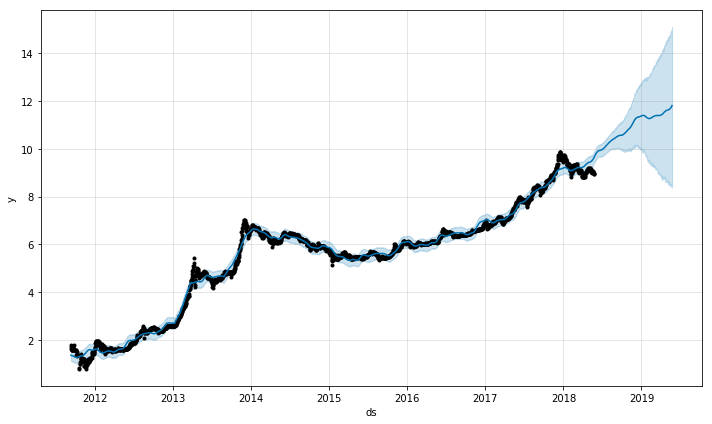

In [14]:
m.plot(forecast);

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

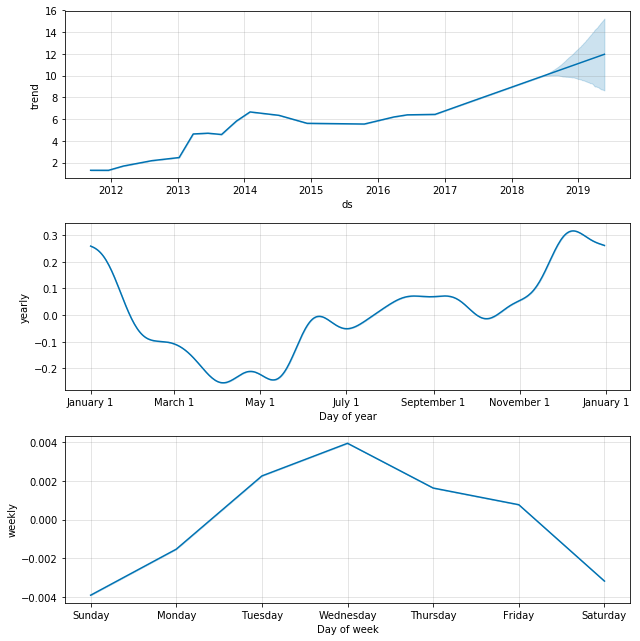

In [15]:
m.plot_components(forecast);

More details about the options available for each method are available in the docstrings, for example, via `help(Prophet)` or `help(Prophet.fit)`.